# About Yulu

Yulu is India’s leading micro-mobility service provider, which offers unique vehicles for the daily commute. Starting off as a mission to eliminate traffic congestion in India, Yulu provides the safest commute solution through a user-friendly mobile app to enable shared, solo and sustainable commuting.

Yulu zones are located at all the appropriate locations (including metro stations, bus stands, office spaces, residential areas, corporate offices, etc) to make those first and last miles smooth, affordable, and convenient!

Yulu has recently suffered considerable dips in its revenues. They have contracted a consulting company to understand the factors on which the demand for these shared electric cycles depends. Specifically, they want to understand the factors affecting the demand for these shared electric cycles in the Indian market.

In [2]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_ind,chi2_contingency,chi2,f_oneway

In [3]:
df = pd.read_csv('/Users/mojo/ML/Scaler/Projects/Yulu Bikes/bike_sharing.csv')
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


Column Profiling:

- datetime: datetime
- season: season (1: spring, 2: summer, 3: fall, 4: winter)
- holiday: whether day is a holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
- workingday: if day is neither weekend nor holiday is 1, otherwise is 0.
- weather:
    - 1: Clear, Few clouds, partly cloudy, partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp: temperature in Celsius
- atemp: feeling temperature in Celsius
- humidity: humidity
- windspeed: wind speed
- casual: count of casual users
- registered: count of registered users
- count: count of total rental bikes including both casual and registered

# EDA

## Problem Statement:
The company wants to know:

- Which variables are significant in predicting the demand for shared electric cycles in the Indian market?
- How well those variables describe the electric cycle demands
- We will have to find dependent and independent variable and try to resolve the problem.


In [4]:
# Shape of the data
df.shape

(10886, 12)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


- We can see that there are no missing values in the data.
- We will have to look into the data types and make changes. 

### Making the appropriate data type.
- datatime > date time type
- Categorical data: season, holiday, weather, working day
- numerical data: temp, atemp, humidity, windspeed, casual, registered, count

In [6]:
# changing the column names

df.rename(columns={'casual':'casual_users', 'registered':'registered_users',
'count':'rental_counts','atemp':'feel_temp'}, inplace=True)

In [7]:
cat_columns = ['season', 'holiday', 'workingday', 'weather']
df['datetime']=df['datetime'].astype('datetime64[ns]')

for col in cat_columns:
    df[col] = df[col].astype('category')
df.dtypes

datetime            datetime64[ns]
season                    category
holiday                   category
workingday                category
weather                   category
temp                       float64
feel_temp                  float64
humidity                     int64
windspeed                  float64
casual_users                 int64
registered_users             int64
rental_counts                int64
dtype: object

In [8]:
# putting actual values instead of numbers
df['season'].replace({1: 'Spring', 2: 'Summer', 3: 'Fall', 4: 'Winter'}, inplace=True)
df['weather'].replace({1:'Clear',2:'Misty Cloudy',3: 'Light Rain',4:'Heavy Rain'}, inplace=True)
df['workingday'].replace({0:'weekend', 1:'weekday'}, inplace=True)

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
temp,10886.0,20.230860,7.791590,0.82,13.9400,20.500,26.2400,41.0000
feel_temp,10886.0,23.655084,8.474601,0.76,16.6650,24.240,31.0600,45.4550
humidity,10886.0,61.886460,19.245033,0.00,47.0000,62.000,77.0000,100.0000
windspeed,10886.0,12.799395,8.164537,0.00,7.0015,12.998,16.9979,56.9969
casual_users,10886.0,36.021955,49.960477,0.00,4.0000,17.000,49.0000,367.0000
registered_users,10886.0,155.552177,151.039033,0.00,36.0000,118.000,222.0000,886.0000
rental_counts,10886.0,191.574132,181.144454,1.00,42.0000,145.000,284.0000,977.0000


- temp, atemp, humidity and windspeed spread doesnt seem to be skewed. 
- casual / registered users and count is spread is skewed data.

## Univariate Analysis

In [10]:
num_columns = ['temp','feel_temp','humidity','windspeed','casual_users', 'registered_users', 'rental_counts']
num_columns, cat_columns

(['temp',
  'feel_temp',
  'humidity',
  'windspeed',
  'casual_users',
  'registered_users',
  'rental_counts'],
 ['season', 'holiday', 'workingday', 'weather'])

#### Count plots for categorical Variables

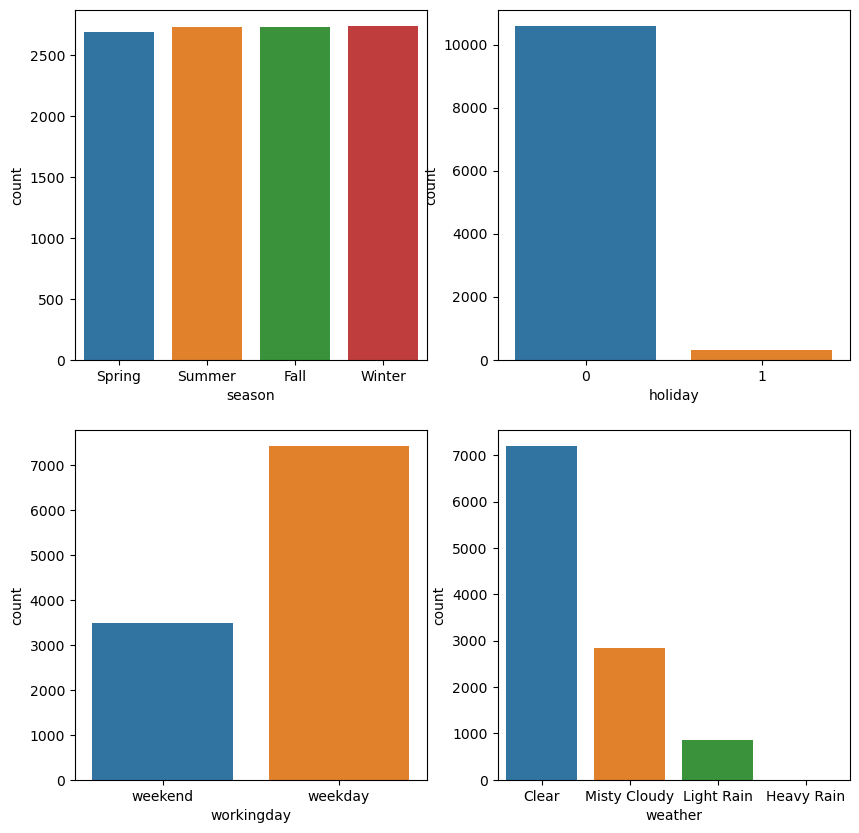

In [11]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
sns.countplot(data=df, x='season', ax=axs[0,0])
sns.countplot(data=df, x='holiday', ax=axs[0,1])
sns.countplot(data=df, x='workingday', ax=axs[1,0])
sns.countplot(data=df, x='weather', ax=axs[1,1])
plt.show()


In [12]:
for col in cat_columns:
    print(df[col].value_counts(normalize=True)*100)

Winter    25.114826
Summer    25.105640
Fall      25.105640
Spring    24.673893
Name: season, dtype: float64
0    97.14312
1     2.85688
Name: holiday, dtype: float64
weekday    68.087452
weekend    31.912548
Name: workingday, dtype: float64
Clear           66.066507
Misty Cloudy    26.033437
Light Rain       7.890869
Heavy Rain       0.009186
Name: weather, dtype: float64


- We can see that all the data contains equal value in all weather. 
- approx only 3 percent is the holidays.
- 68% of days are working days.
- There is only 1 day where the rains was heavy. 
- 66% of the days were clear during most trips.

In [13]:
num_columns

['temp',
 'feel_temp',
 'humidity',
 'windspeed',
 'casual_users',
 'registered_users',
 'rental_counts']

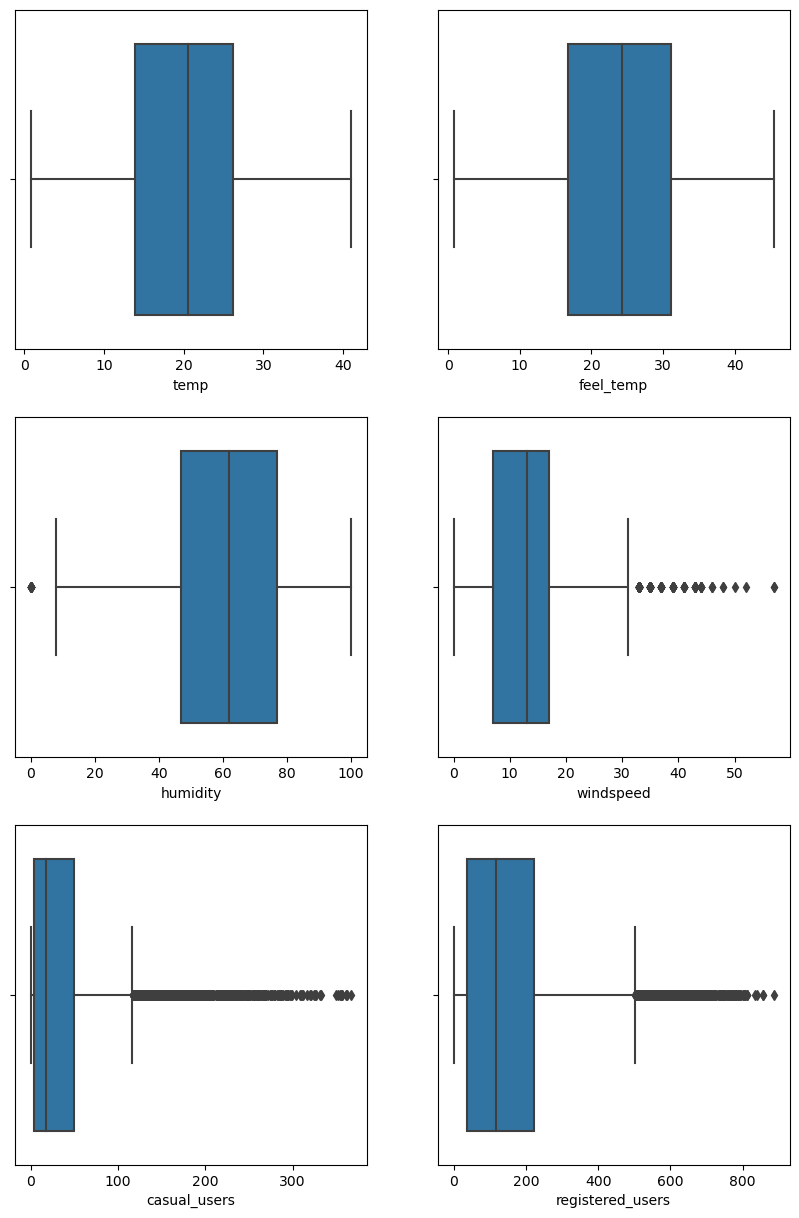

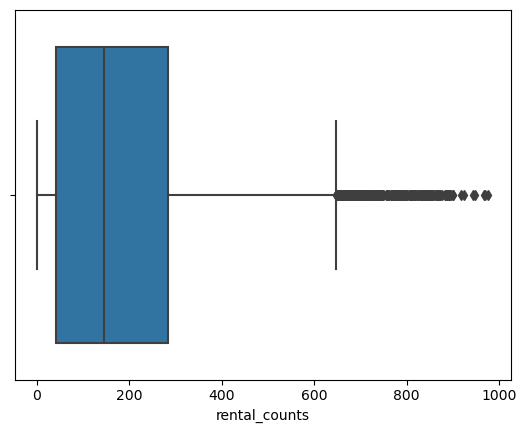

In [14]:
# Box plots
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10,15))
sns.boxplot(data=df, x='temp', ax=axs[0,0])
sns.boxplot(data=df, x='feel_temp', ax=axs[0,1])
sns.boxplot(data=df, x='humidity', ax=axs[1,0])
sns.boxplot(data=df, x='windspeed', ax=axs[1,1])
sns.boxplot(data=df, x='casual_users', ax=axs[2,0])
sns.boxplot(data=df, x='registered_users', ax=axs[2,1])
plt.show()
sns.boxplot(data=df, x='rental_counts')
plt.show()

- There are no outliers in temp, feel_temp and humidity
- windspeed, both type of users and rental_counts have lots of outliers

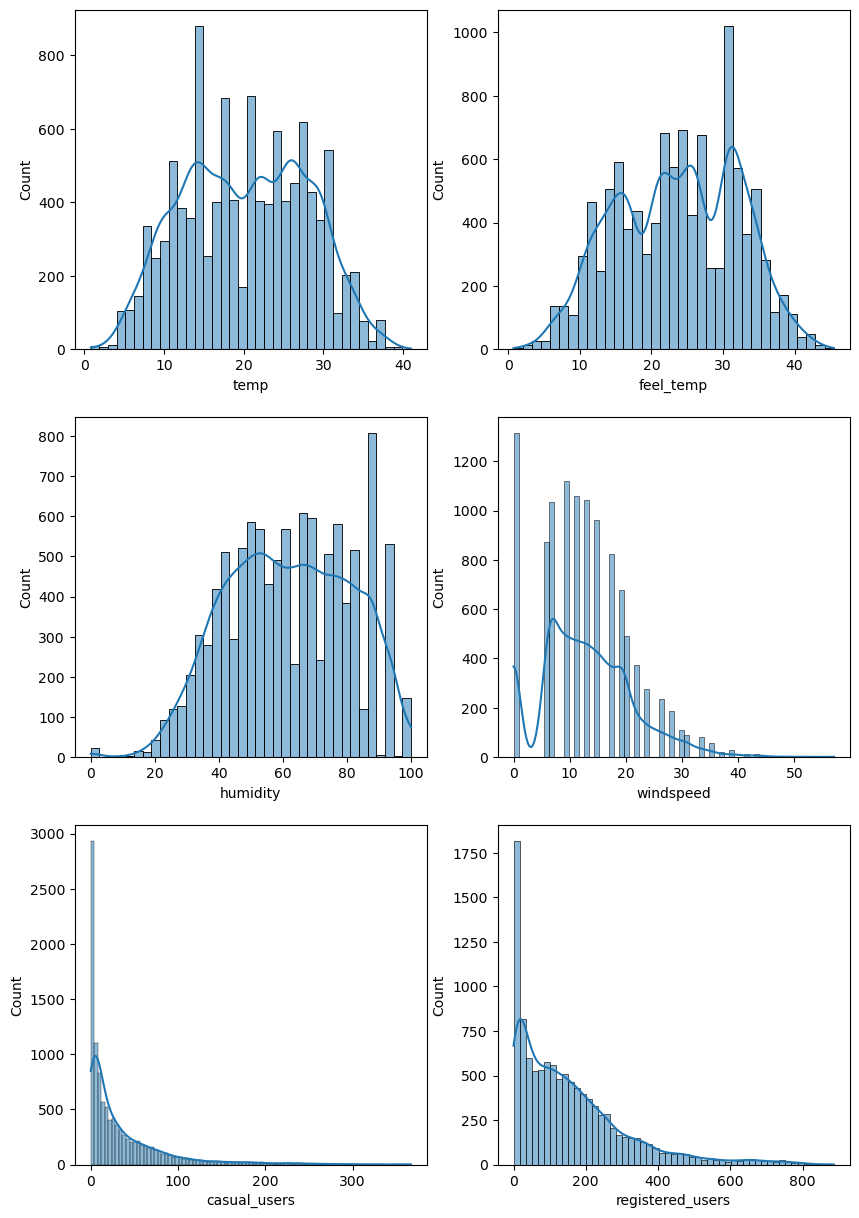

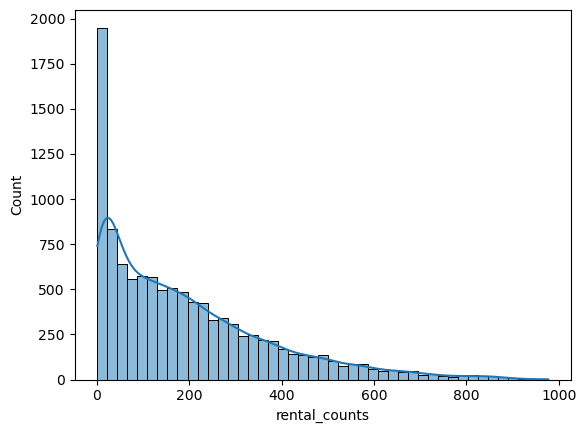

In [15]:
# Histograms and KDE plots
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10,15))
sns.histplot(data=df, x='temp', ax=axs[0,0], kde=True)
sns.histplot(data=df, x='feel_temp', ax=axs[0,1], kde=True)
sns.histplot(data=df, x='humidity', ax=axs[1,0], kde=True)
sns.histplot(data=df, x='windspeed', ax=axs[1,1], kde=True)
sns.histplot(data=df, x='casual_users', ax=axs[2,0], kde=True)
sns.histplot(data=df, x='registered_users', ax=axs[2,1], kde=True)
plt.show()
sns.histplot(data=df, x='rental_counts', kde=True)
plt.show()

In [16]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
temp,10886.0,20.230860,7.791590,0.82,13.9400,20.500,26.2400,41.0000
feel_temp,10886.0,23.655084,8.474601,0.76,16.6650,24.240,31.0600,45.4550
humidity,10886.0,61.886460,19.245033,0.00,47.0000,62.000,77.0000,100.0000
windspeed,10886.0,12.799395,8.164537,0.00,7.0015,12.998,16.9979,56.9969
casual_users,10886.0,36.021955,49.960477,0.00,4.0000,17.000,49.0000,367.0000
registered_users,10886.0,155.552177,151.039033,0.00,36.0000,118.000,222.0000,886.0000
rental_counts,10886.0,191.574132,181.144454,1.00,42.0000,145.000,284.0000,977.0000


- As we have noticed the distribution mean is in the right of median this means the data is left skewed. 

### Bi variate analysis


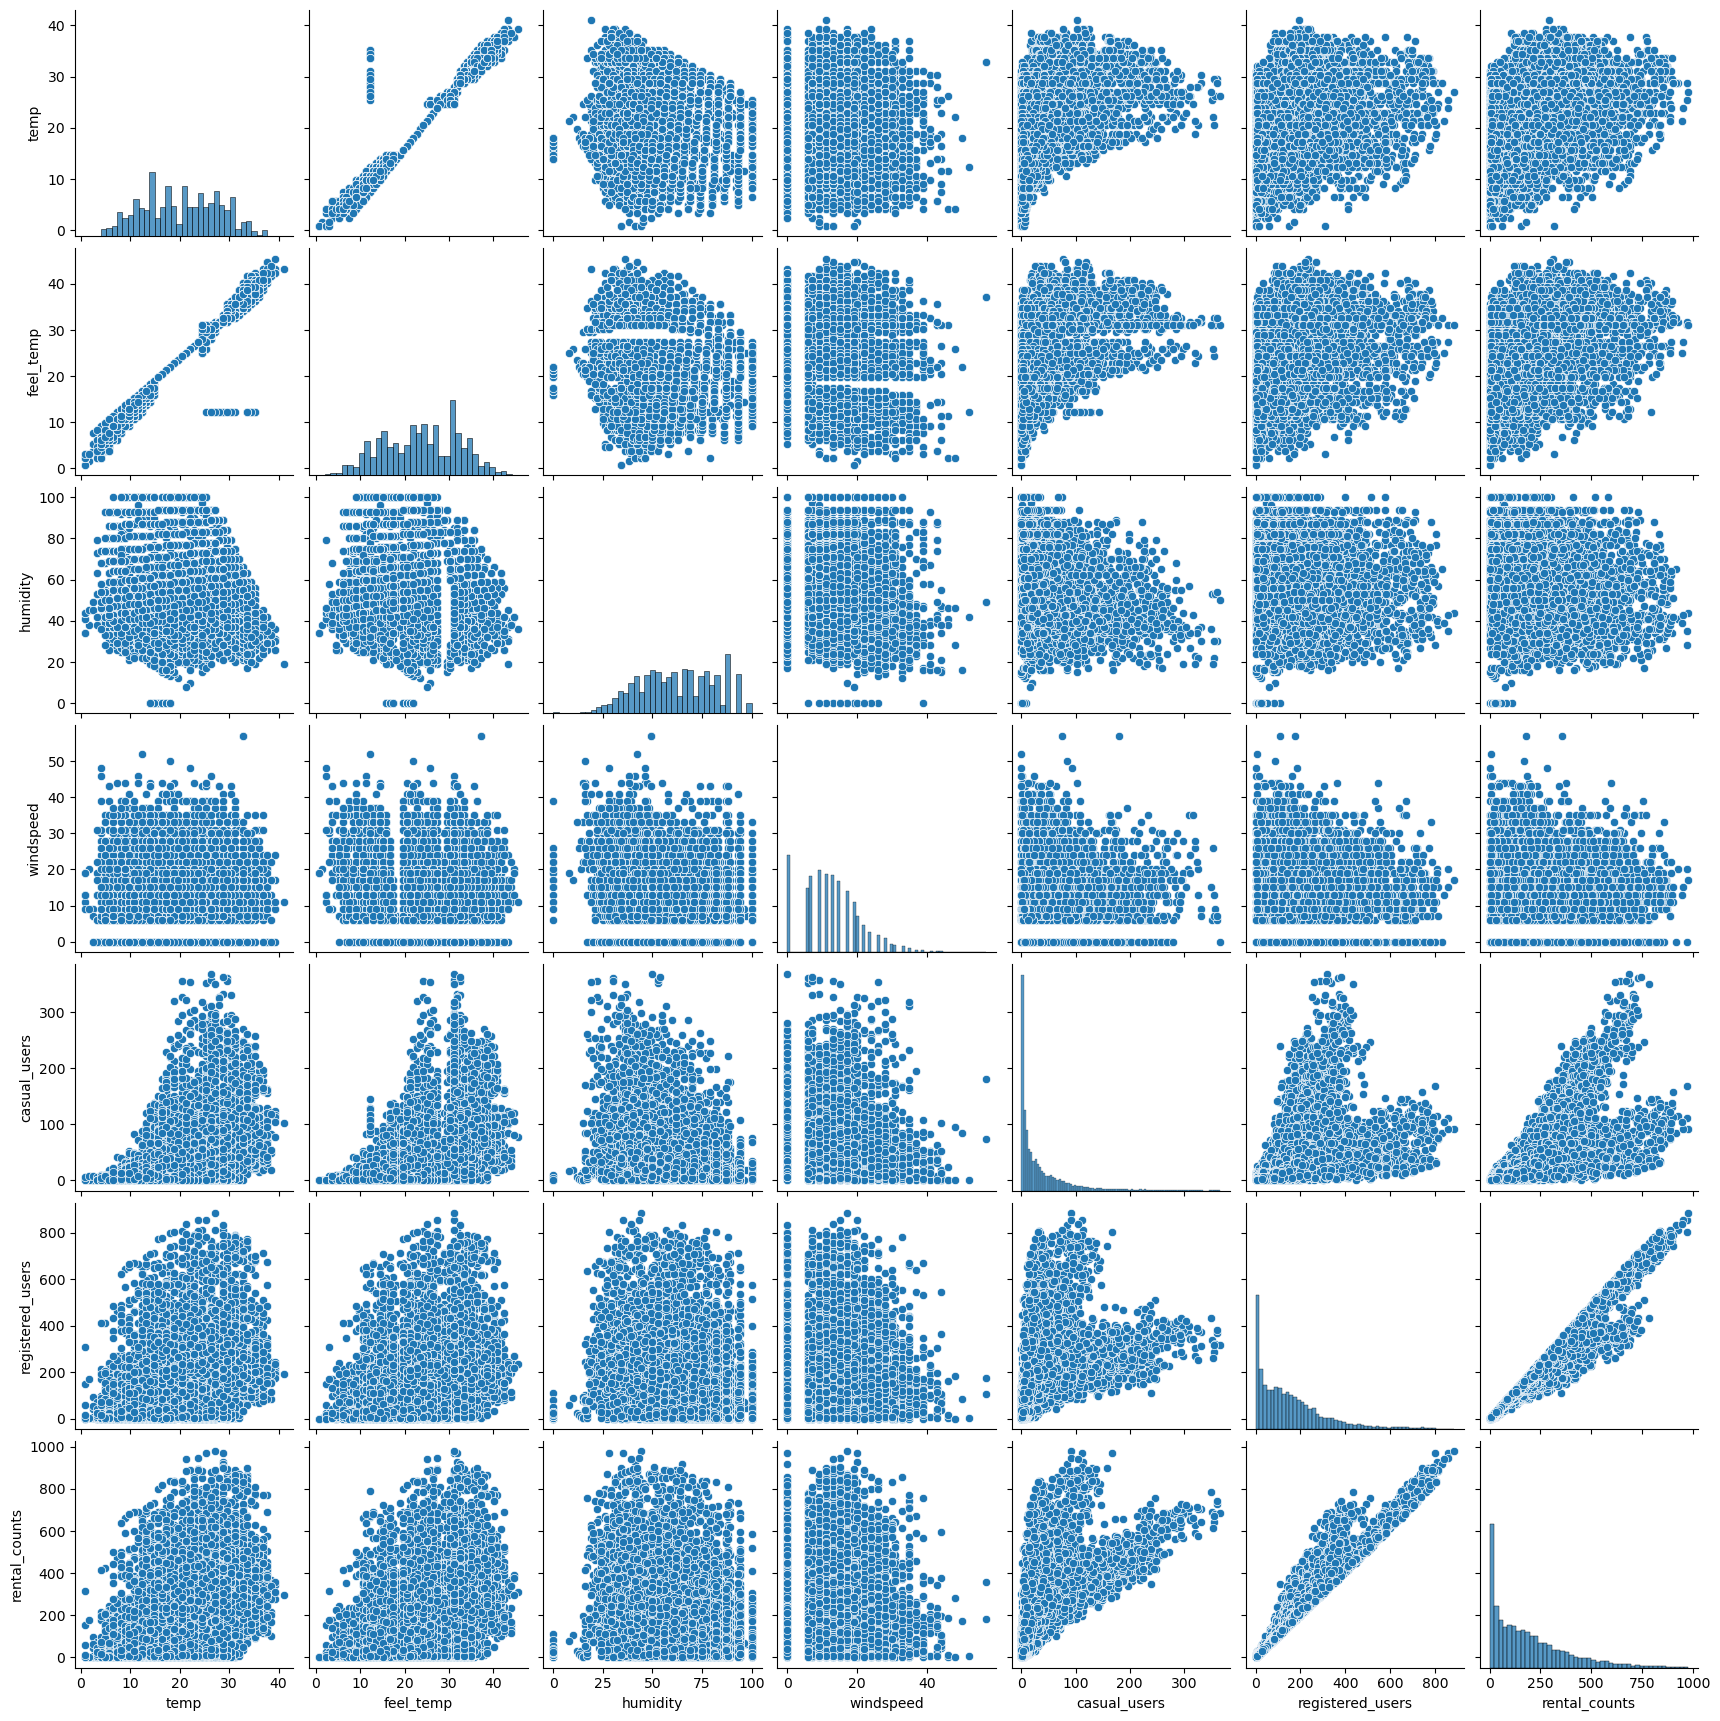

In [17]:
sns.pairplot(df[num_columns]);

- We can see that rental counts has increased with registerd_users
- Rental counts has always incresed with casual users too.

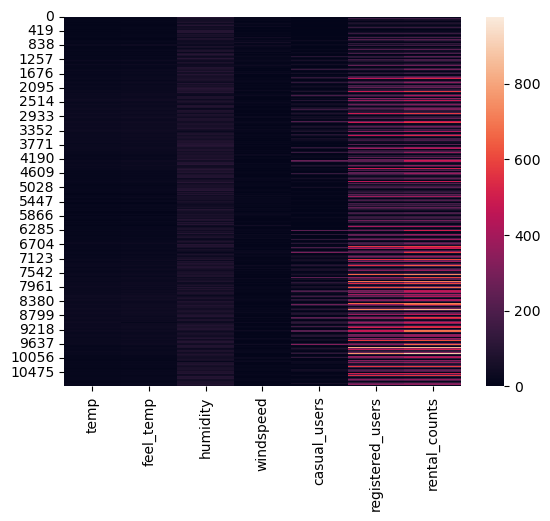

In [18]:
sns.heatmap(df[num_columns]);

- We can see that we can't get much information out of the data pair plots and heat maps.

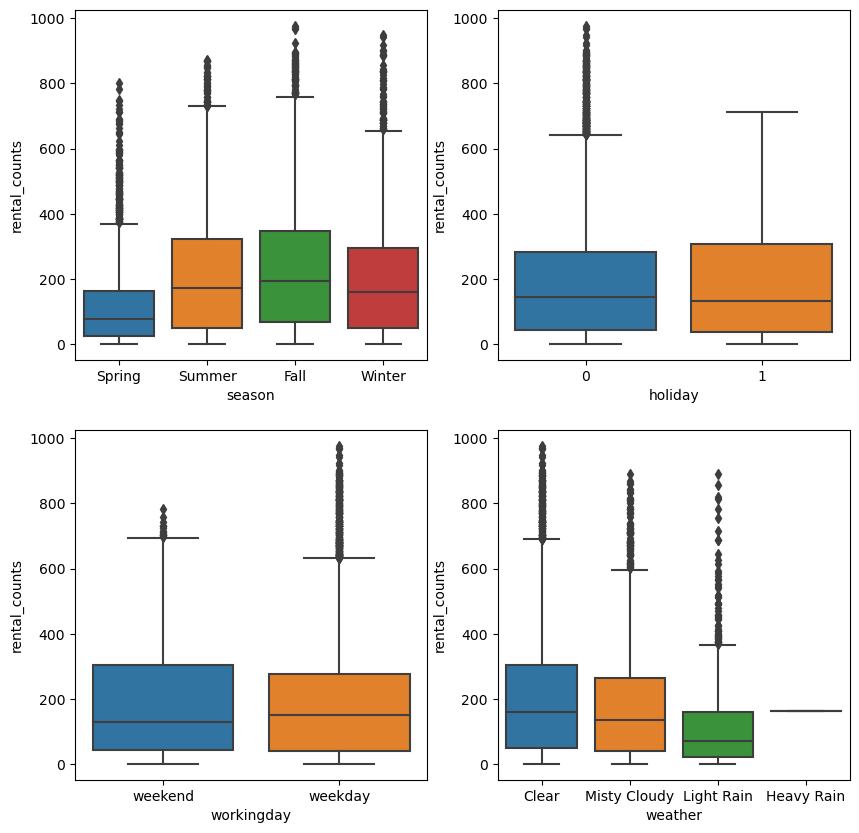

In [19]:
fig, axis = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

index = 0
for row in range(2):
    for col in range(2):
        sns.boxplot(data=df, x=cat_columns[index], y='rental_counts', ax=axis[row, col])
        index += 1
        
plt.show()

- Fall > Summer > Winter > Spring. We can see that Spring Season is the least contributor.
- We don't have enoguh data for heavy rains
- On Clear and couldy days bike rentals were highest.
- Rentals counts are same whether there it is a working day or not. 
- There are lots of outliers in all type of features.


# Hypothesis Testing

## 2- Sample T-Test 
If Working Day has effect on number of electric cycles
rented

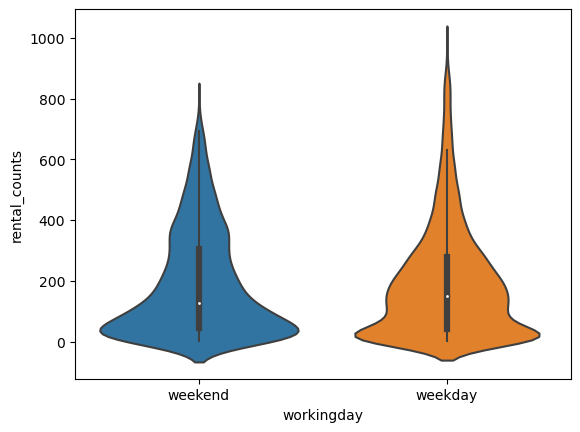

In [20]:
sns.violinplot(data=df, x= 'workingday', y='rental_counts');

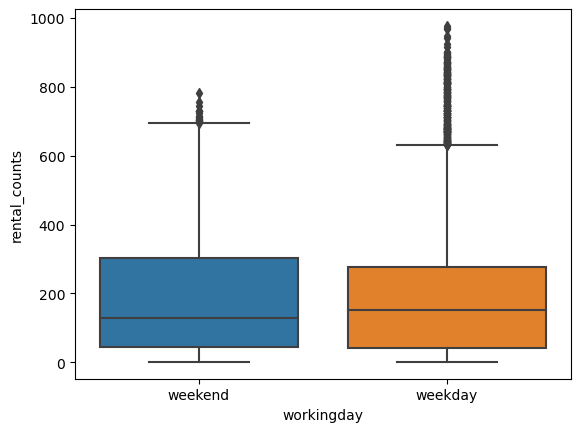

In [21]:
sns.boxplot(data=df, x= 'workingday', y='rental_counts');

- We can see that the rental count is almost same on weekend and weekdays.

#### Define Null and Aleternate Hypothesis.
- Null Hyposthesis (H0): Rental counts are same on weekdays and weekends.
    -  u1 = u2
- Alternate Hyposthesis (H): Rental counts are more on weekdays in comparison with weekends.
    - u1 > u2
#### Select Appropriate Test
- This is a one-tailed test concerning two population means from two independent populations. As the population standard deviations are unknown, the two sample independent t-test will be the appropriate test for this problem.
#### Step 3: Decide the significance level

As given in the problem statement, we select α = 0.05.

#### Step 4: Collect and prepare data



In [22]:
df['workingday'].value_counts()

weekday    7412
weekend    3474
Name: workingday, dtype: int64

In [23]:
weekday = df[df['workingday'] == 'weekday']['rental_counts'].sample(3474)
weekend = df[df['workingday'] == 'weekend']['rental_counts'].sample(3474)

In [24]:
# Calculate p-values
alpha = 0.05
test_stat, p_value = ttest_ind(weekday, weekend, equal_var = False, alternative = 'greater')
print('The p-value is', p_value)

The p-value is 0.026142712510849923


In [25]:
# print the conclusion based on p-value
if p_value < alpha:
    print(f'As the p-value {p_value} is less than the level of significance, we reject the null hypothesis.')
else:
    print(f'As the p-value {p_value} is greater than the level of significance, we fail to reject the null hypothesis.')

As the p-value 0.026142712510849923 is less than the level of significance, we reject the null hypothesis.


### Hyposthesis Testing 2
Chi-square test to check if Weather is dependent on season

- Null Hypothesis (H0): Weather is independent of the season
- Alternate Hypothesis (H1): Weather is not independent of the season
- Significance level (alpha): 0.05

We will use **chi-square test** to test hypyothesis defined above.

In [26]:
data_table = pd.crosstab(df['season'], df['weather'])
print("Observed values:")
data_table

Observed values:


weather,Clear,Misty Cloudy,Light Rain,Heavy Rain
season,,,,
Spring,1759,715,211,1
Summer,1801,708,224,0
Fall,1930,604,199,0
Winter,1702,807,225,0


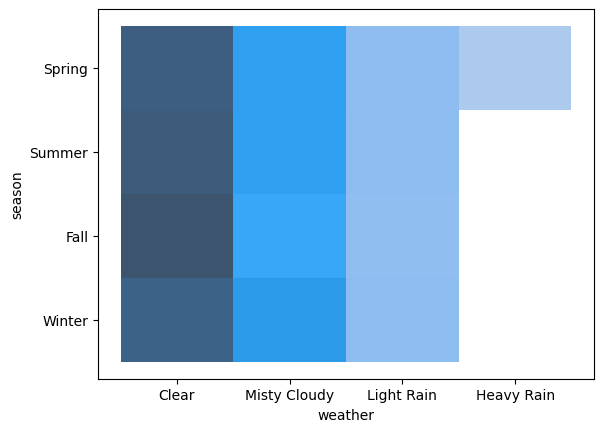

In [27]:
# sns.histplot(binwidth=1,
#             x=first_dimension,
#             hue=second_dimension,
#             data=df,
#             stat="count",
#             multiple="dodge")
sns.histplot(data=df, x='weather',y='season', stat='count');

In [28]:
# val = chi2_contingency(data_table)
# expected_values = val[3]
# expected_values

array([[1.77454639e+03, 6.99258130e+02, 2.11948742e+02, 2.46738931e-01],
       [1.80559765e+03, 7.11493845e+02, 2.15657450e+02, 2.51056403e-01],
       [1.80559765e+03, 7.11493845e+02, 2.15657450e+02, 2.51056403e-01],
       [1.80625831e+03, 7.11754180e+02, 2.15736359e+02, 2.51148264e-01]])

In [33]:
nrows, ncols = 4, 4
print("degrees of freedom: ", (nrows-1)*(ncols-1))
alpha = 0.05

chi_stat, p_value, df, exp_freq = chi2_contingency(data_table)
# print the conclusion based on p-value
if p_value < 0.05:
    print(f'As the p-value {p_value} is less than the level of significance, we reject the null hypothesis.')
    print('Season is dependent on weather')
else:
    print(f'As the p-value {p_value} is greater than the level of significance, we fail to reject the null hypothesis.')

degrees of freedom:  9
As the p-value 1.5499250736864915e-07 is less than the level of significance, we reject the null hypothesis.
Season is dependent on weather


### Hypothesis Testing - 3

**Null Hypothesis:** Number of cycles rented is similar in different weather and season.

**Alternate Hypothesis:** Number of cycles rented is not similar in different weather and season.

**Significance level (alpha): 0.05**

Here, we will use the **ANOVA** to test the hypothess defined above

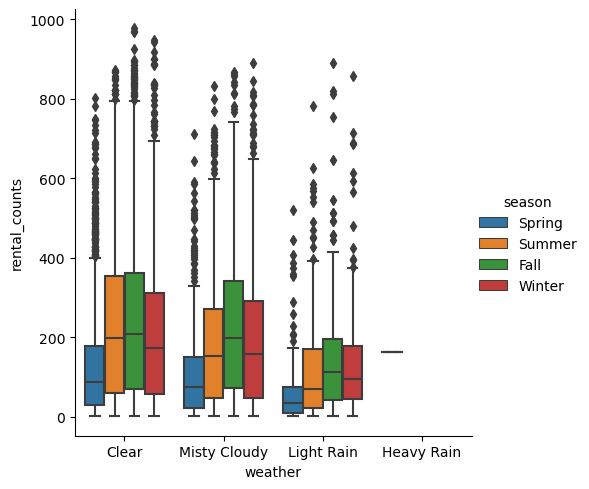

In [30]:
sns.catplot(data=df, x= 'weather', y='rental_counts', hue='season', kind='box');

In [31]:
# defining the data groups for the ANOVA
# we are ignoring the heavy rain days
gp1 = df[df['weather']=='Clear']['rental_counts'].values
gp2 = df[df['weather']=='Misty Cloudy']['rental_counts'].values
gp3 = df[df['weather']=='Light Rain']['rental_counts'].values
gp4 = df[df['season']=='Spring']['rental_counts'].values
gp5 = df[df['season']=='Summer']['rental_counts'].values
gp6 = df[df['season']=='Fall']['rental_counts'].values
gp7 = df[df['season']=='Winter']['rental_counts'].values

# conduct the one-way anova
print(f_oneway(gp1, gp2, gp3, gp4, gp5, gp6,gp7))

# print the conclusion based on p-value
if p_value < 0.05:
    print(f'As the p-value {p_value} is less than the level of significance, we reject the null hypothesis.')
else:
    print(f'As the p-value {p_value} is greater than the level of significance, we fail to reject the null hypothesis.')



F_onewayResult(statistic=149.2903613073192, pvalue=2.2725083985065216e-186)
As the p-value 0.026142712510849923 is less than the level of significance, we reject the null hypothesis.


### Insights

- In summer and fall seasons more bikes are rented as compared to other seasons.
- Whenever its a holiday more bikes are rented.
- It is also clear from the workingday also that whenever day is holiday or weekend, slightly more bikes were rented.
- Whenever there is rain, thunderstorm, snow or fog, there were less bikes were rented. 


- Whenever the humidity is less than 20, number of bikes rented is very very low.
- Whenever the temperature is less than 10, number of bikes rented is less.
- Whenever the windspeed is greater than 35, number of bikes rented is less.


### Recommendations
- In summer and fall seasons the company should have more bikes in stock to be rented. Because the demand in these seasons is higher as compared to other seasons.
- With a significance level of 0.05, workingday has no effect on the number of bikes being rented.
- In very low humid days, company should have less bikes in the stock to be rented.
- Whenever temprature is less than 10 or in very cold days, company should have less bikes.
- Whenever the windspeed is greater than 35 or in thunderstorms, company should have less bikes in stock to be rented.